In [1]:
import os
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import re
import matplotlib.pyplot as plt
import statistics
import pywt
from pywt import wavedec

# Create dataframe for signals with their labels

In [2]:
path = r'./3-class-clean'

In [3]:
files = os.listdir(path)

In [4]:
# Mapping directions letters to Turkish words to make data easy to understand
class_map = {
    "yukari":"u",
    "asagi":"d",
    "sag":"r",
    "sol":"l",
    "kirp":"b"
}

In [5]:
# Creating dataframe to contain signals and their true directions
data = pd.DataFrame()
ids = []
horizontal = []
vertical = []
labels = []

In [6]:
# Reading files and storing content in lists
for i in range(0,len(files),2):
    file1 = path+ r"/" + files[i]
    file2 = path+ r"/" + files[i+1]
    sig_id = re.findall(r'\d+', files[i])
    ids.append(int(sig_id[0]))
    h = np.loadtxt(file1, dtype=int)
    v = np.loadtxt(file2, dtype=int)
    horizontal.append(h)
    vertical.append(v)
    labels.append(class_map[files[i].split(sig_id[0])[0]])

In [7]:
# Initializing columns
data["ID"] = ids
data["Horizontal"] = horizontal
data["Vertical"] = vertical
data["Label"] = labels

In [8]:
data.shape

(100, 4)

In [9]:
data.head()

,ID,Horizontal,Vertical,Label
0,10,"[123, 126, 134, 131, 125, 131, 130, 127, 133, ...","[123, 122, 127, 130, 123, 123, 127, 128, 125, ...",d
1,11,"[127, 135, 130, 135, 129, 127, 133, 131, 130, ...","[120, 132, 120, 127, 126, 125, 120, 125, 122, ...",d
2,12,"[133, 137, 134, 132, 137, 136, 135, 136, 136, ...","[136, 130, 141, 136, 137, 135, 144, 133, 143, ...",d
3,13,"[147, 143, 152, 147, 146, 150, 144, 145, 146, ...","[148, 150, 139, 144, 144, 144, 139, 148, 142, ...",d
4,14,"[122, 128, 128, 124, 129, 127, 127, 127, 124, ...","[118, 112, 121, 120, 116, 115, 119, 116, 118, ...",d


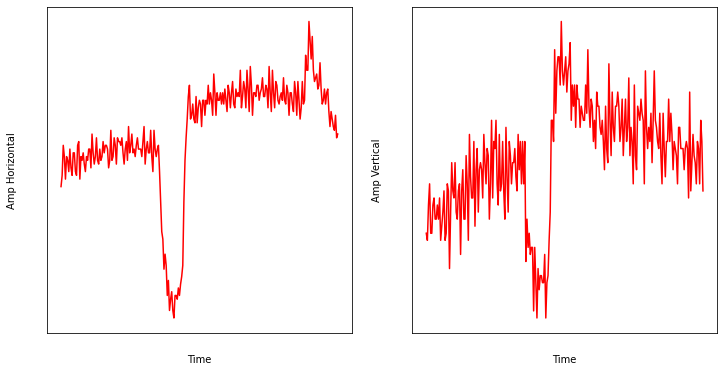

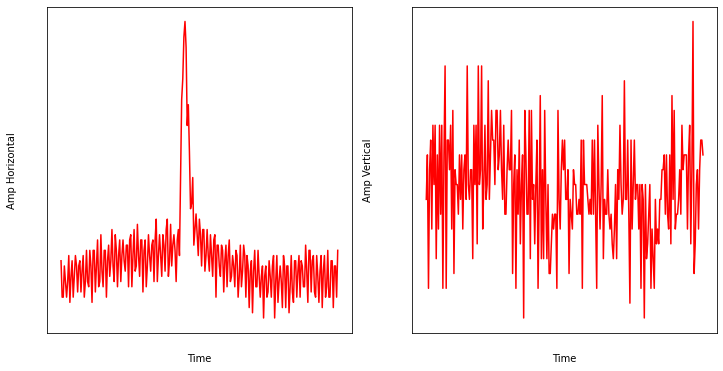

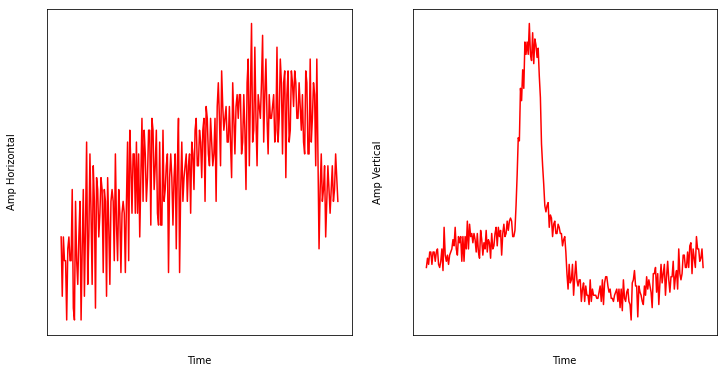

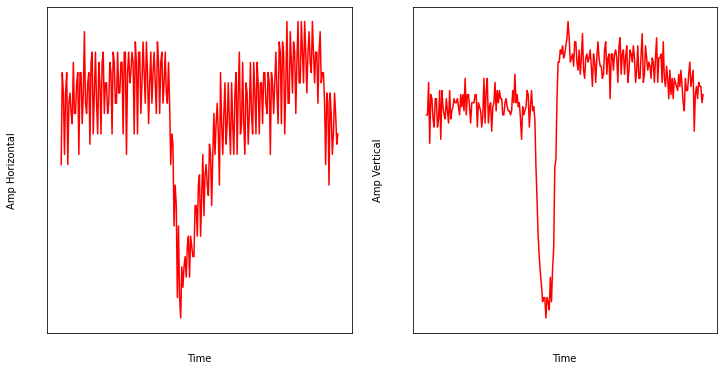

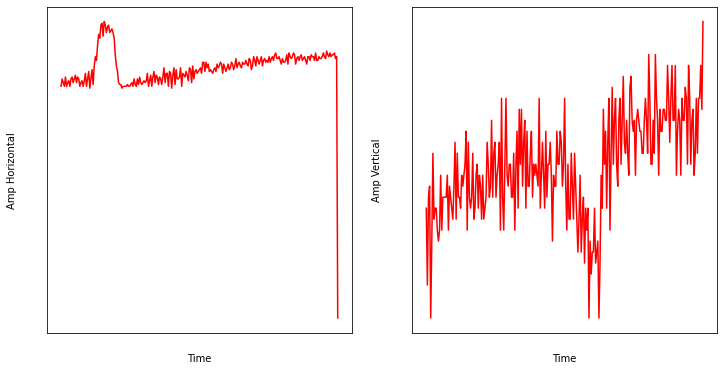

In [10]:
# Plotting H & V signals for single record in each direction
for i in range(0,data.shape[0],20):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(np.arange(data.iloc[i]["Horizontal"].size) ,data.iloc[i]["Horizontal"],'r')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.xlabel('Time')
    plt.ylabel('Amp Horizontal')
    plt.subplot(122)
    plt.plot(np.arange(data.iloc[i]["Vertical"].size),data.iloc[i]["Vertical"],'r')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.xlabel('Time')
    plt.ylabel('Amp Vertical')

In [11]:
# Creating Butterworth band pass filter
b,a = signal.butter(2,[1,25],btype = 'band',analog=False, output='ba', fs=176)

In [12]:
# Funcion to make complete preprocessing on signal (filtering, resampling, dc_removal, normalization)
def preprocess_signal(np_signal):
    filtered = signal.filtfilt(b,a,np_signal)
    resampled = signal.resample(filtered,60)
    mean = statistics.mean(resampled)
    dc_removed = np.array([(sample - mean) for sample in resampled])
    norm = np.linalg.norm(dc_removed)
    normalized = dc_removed / norm
    return normalized

In [13]:
# Applying preprocessing on signals
data["Horizontal"] = data["Horizontal"].apply(lambda sig: preprocess_signal(sig))
data["Vertical"] = data["Vertical"].apply(lambda sig: preprocess_signal(sig))

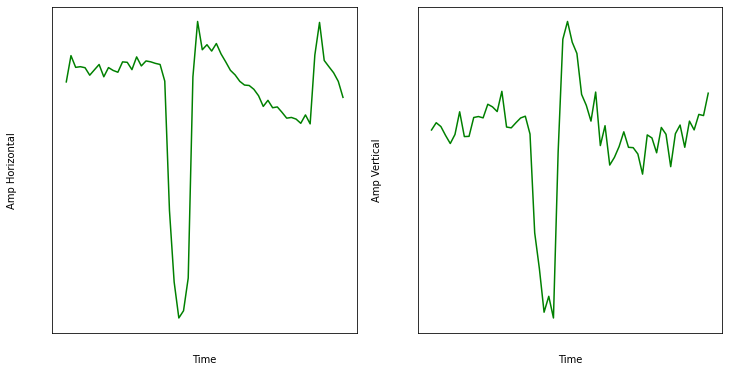

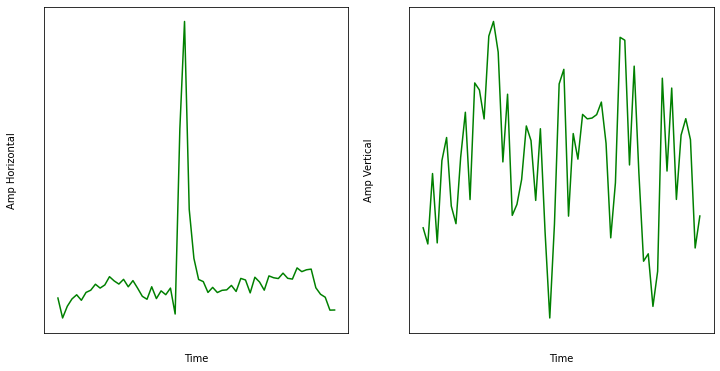

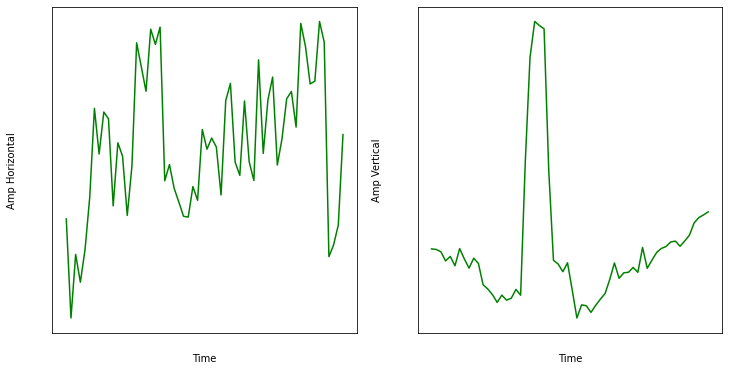

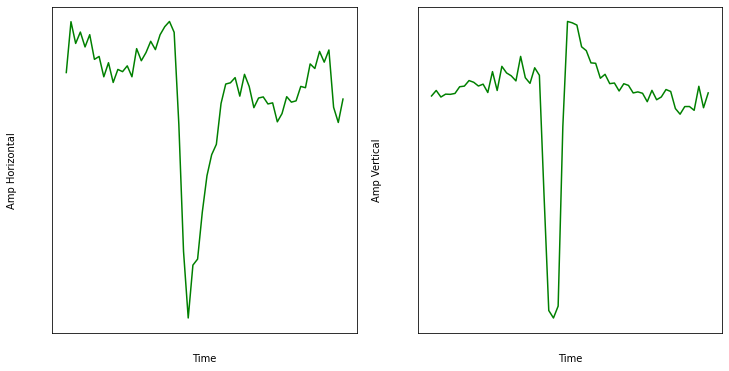

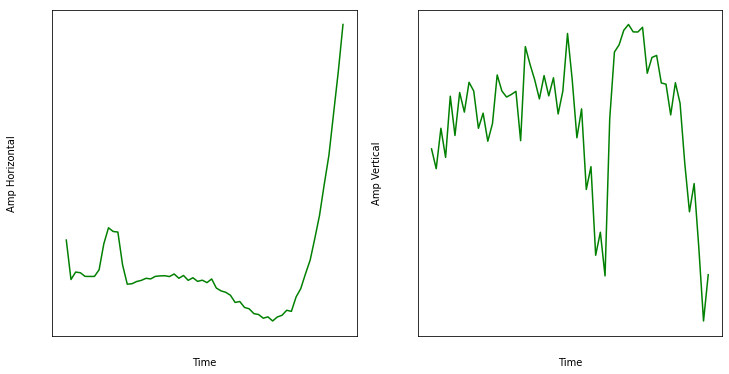

In [14]:
# Plotting sample signals after preprocessing
for i in range(0,data.shape[0],20):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(np.arange(data.iloc[i]["Horizontal"].size) ,data.iloc[i]["Horizontal"],'g')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.xlabel('Time')
    plt.ylabel('Amp Horizontal')
    plt.subplot(122)
    plt.plot(np.arange(data.iloc[i]["Vertical"].size),data.iloc[i]["Vertical"],'g')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.xlabel('Time')
    plt.ylabel('Amp Vertical')

# Feature Extraction

In [15]:
import scipy
import scipy.integrate as integrate
from scipy.signal import find_peaks

In [16]:
# Function to extract wavelet features
def analyze_w_wavelet(np_signal):
    coefs = wavedec(np_signal,'db4',level = 3)
    features = [coefs[0],coefs[1],coefs[2]]
    return features

In [17]:
# Function to extract peak features
def peak_features(signal):
    peaks = find_peaks(signal)
    Y=[]
    for i in range(len(peaks)-1):
        Y.append(signal[i])
    return max(Y)

In [18]:
# Function to extract area under curve
def area_features(signal):
    return integrate.simps(signal)

In [19]:
# Function to calculate PSD for signal
def psd_features(signal,fs):
    (f, S) = scipy.signal.periodogram(signal, fs, scaling='density')
    return S

In [20]:
# extracting wavelet and PSD features and flattening wavelet coefficiens
data["H_W_Features"] = data["Horizontal"].apply(lambda x: [item for sublist in analyze_w_wavelet(x) for item in sublist])
data["V_W_Features"] = data["Vertical"].apply(lambda x: [item for sublist in analyze_w_wavelet(x) for item in sublist])
data["H_PSD_Features"] = data["Horizontal"].apply(lambda x: psd_features(x,50))
data["V_PSD_Features"] = data["Vertical"].apply(lambda x: psd_features(x,50))

In [21]:
# Creating new dataframe that contains all features
h_w_features = data["H_W_Features"].apply(pd.Series)
v_w_features = data["V_W_Features"].apply(pd.Series)
h_psd_features = data["H_PSD_Features"].apply(pd.Series)
v_psd_features = data["V_PSD_Features"].apply(pd.Series)
features = pd.concat([h_w_features, h_psd_features ,v_w_features, v_psd_features], axis=1)
features["H_area"] = data["Horizontal"].apply(lambda x: area_features(x))
features["H_peak"] = data["Horizontal"].apply(lambda x: peak_features(x))
features["V_area"] = data["Vertical"].apply(lambda x: area_features(x))
features["V_peak"] = data["Vertical"].apply(lambda x: peak_features(x))
features["Label"] = data["Label"]

# Model Selection and Training

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,GradientBoostingClassifier,VotingClassifier

In [23]:
# Applying train-test-split for evaluating the model
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns = ["Label"]), features["Label"], stratify=features["Label"], test_size=0.25)

In [24]:
# Initializing models to train them and comparing results
# model1 = LinearSVC(penalty = 'l1',dual = False ,max_iter = 5000)
# model2 = AdaBoostClassifier(n_estimators = 100)
# model3 = RandomForestClassifier(n_estimators = 200, criterion = 'entropy',max_features = 'log2',
#                                 bootstrap = False,n_jobs = -1,warm_start = True)
# model4 = GradientBoostingClassifier(n_estimators = 200,warm_start = True)
# model5 = ExtraTreesClassifier(n_estimators = 200,criterion = 'entropy',bootstrap = False,n_jobs = -1,
#                               warm_start = True)
model1 = LinearSVC()
model2 = AdaBoostClassifier()
model3 = RandomForestClassifier()
model4 = GradientBoostingClassifier()
model5 = ExtraTreesClassifier()

In [25]:
model6 = VotingClassifier(estimators=[('et', ExtraTreesClassifier()), ('rf', RandomForestClassifier())],voting='soft')

In [26]:
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
accuracy_score(y_test, y_pred1)

0.64

In [27]:
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy_score(y_test, y_pred2)

0.36

In [40]:
model3.fit(X_train,y_train)
y_pred3 = model3.predict(X_test)
accuracy_score(y_test, y_pred3)

1.0

In [41]:
model4.fit(X_train,y_train)
y_pred4 = model4.predict(X_test)
accuracy_score(y_test, y_pred4)

0.68

In [84]:
model5.fit(X_train,y_train)
y_pred5 = model5.predict(X_test)
accuracy_score(y_test, y_pred5)

1.0

In [115]:
model6.fit(X_train,y_train)
y_pred6 = model6.predict(X_test)
accuracy_score(y_test, y_pred6)

1.0

# Saving Best Models 

In [116]:
import joblib

In [117]:
joblib.dump(model3, 'RandomForestClassifier.sav')

['RandomForestClassifier.sav']

In [118]:
joblib.dump(model5, 'ExtraTreesClassifier.sav')

['ExtraTreesClassifier.sav']

In [119]:
joblib.dump(model6, 'VotingClassifier.sav')

['VotingClassifier.sav']